In [1]:
import random
import typing as tp
import csv
import pickle
import re
from collections import Counter

import numpy as np
import keras
import keras.layers
import keras.optimizers
import keras.callbacks
from keras.utils import pad_sequences, to_categorical
from keras.preprocessing.text import Tokenizer
from tqdm import tqdm
from matplotlib import pyplot as plt


In [2]:
MODEL_NAME = "StructureModelPOL"
POL = True if MODEL_NAME.endswith('POL') else False

TO_EXCLUDE = '!"#$%&()*+-—/:;<=>@[\\]^_`{|}~.,:;!?\t«»'
TO_TOKENIZE = '\n'

In [3]:
def load_data(file, include: str, exclude: str, size: int = None):
    _text =  []
    with open(file, encoding='UTF-8') as f:
        data = csv.reader(f)
        for verse, *_ in tqdm(list(data)[:size] if size is not None else list(data)):
            # Separate characters that we want to tokenize
            correct_verse = re.sub(r'(['+include+'])', r' \1 ', verse)
            # Exclude characters that we do not want to tokenize
            correct_verse = correct_verse.translate(str.maketrans('', '', exclude))
            _text.append(correct_verse.lower())
    return _text

if POL:
    TEXT = load_data('data/poems/pl/treny.csv', TO_TOKENIZE, TO_EXCLUDE)
    TEXT += load_data('data/poems/pl/slowacki.csv', TO_TOKENIZE, TO_EXCLUDE)
else:
    TEXT = load_data('data/poems/eng/limericks.csv', TO_TOKENIZE, TO_EXCLUDE, 4000)

print(*TEXT[:3])

100%|██████████| 713/713 [00:00<00:00, 32404.42it/s]

wszytki płacze wszytki łzy heraklitowe 
 i lamenty i skargi symonidowe 
 wszytki troski na świecie wszytki wzdychania 
 i żale i frasunki i rąk łamania 
  wszytki a wszytki za raz w dom się mój noście 
 a mnie płakać mej wdzięcznej dziewki pomożcie 
 z którą mię niepobożna śmierć rozdzieliła 
 i wszytkich moich pociech nagle zbawiła 
  tak więc smok upatrzywszy gniazdko kryjome 
 słowiczki liche zbiera a swe łakome 
 gardło pasie tymczasem matka szczebiece 
 uboga a na zbójcę coraz się miece 
 


In [4]:
TOKENIZER = Tokenizer(filters=TO_EXCLUDE)
TOKENIZER.fit_on_texts(TEXT)
WORD_COUNTER = Counter(' '.join(TEXT).split(' '))
TOTAL_WORDS = TOKENIZER.num_words or len(TOKENIZER.word_index) + 1

print(f"Total number of words: {TOTAL_WORDS}")
print(f"Number of words occurrence: {sorted(dict(WORD_COUNTER).items(), key=lambda x: x[1], reverse=True)[:20]}")

Total number of words: 6882
Number of words occurrence: [('\n', 3435), ('', 1399), ('i', 655), ('w', 473), ('na', 379), ('się', 363), ('nie', 361), ('z', 273), ('a', 259), ('jak', 198), ('co', 149), ('to', 148), ('że', 139), ('tak', 127), ('o', 125), ('do', 125), ('mi', 101), ('za', 97), ('lecz', 88), ('ty', 87)]


In [5]:
def create_sequences(text, tokenizer):
    sequences = list()
    for verse in tqdm(text):
        encoded = tokenizer.texts_to_sequences([verse])[0]
        for i in range(1, len(encoded)):
            sequence = encoded[:i + 1]
            sequences.append(sequence)
    return sequences

SEQUENCES = create_sequences(TEXT, TOKENIZER)
print(f"Total Sequences: {len(SEQUENCES)}")

100%|██████████| 859/859 [00:00<00:00, 6160.85it/s]

Total Sequences: 22451


In [6]:
SEQUENCE_LENGTH = max([len(seq) for seq in SEQUENCES])
ENCODED_SEQUENCES = pad_sequences(SEQUENCES, maxlen=SEQUENCE_LENGTH, padding='pre')
X, y = ENCODED_SEQUENCES[:,:-1], to_categorical(ENCODED_SEQUENCES[:,-1], num_classes=TOTAL_WORDS)
print(f'Max Sequence Length: {SEQUENCE_LENGTH}')

Max Sequence Length: 40


In [13]:
def create_model(total_words: int, sequence_length: int):
    # define model
    model = keras.models.Sequential()
    model.add(keras.layers.Embedding(total_words, 256, input_length=sequence_length - 1))
    model.add(keras.layers.LSTM(256, return_sequences=True, activation='relu'))
    model.add(keras.layers.Dropout(0.1))
    model.add(keras.layers.LSTM(128, activation='relu'))
    model.add(keras.layers.Dropout(0.1))
    model.add(keras.layers.Dense(total_words, activation='softmax'))
    opt = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

MODEL_PATH = f"data/models/{MODEL_NAME}/weights.h5"
# MODEL = keras.models.load_model(MODEL_PATH)
MODEL = create_model(TOTAL_WORDS, SEQUENCE_LENGTH)
print(MODEL.summary())


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 39, 256)           1761792   
                                                                 
 lstm_3 (LSTM)               (None, 39, 256)           525312    
                                                                 
 dropout_3 (Dropout)         (None, 39, 256)           0         
                                                                 
 lstm_4 (LSTM)               (None, 128)               197120    
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 6882)              887778    
                                                                 
Total params: 3,372,002
Trainable params: 3,372,002
No

In [14]:
REVERSE_TOKEN_INDEX = {v: k for k, v in TOKENIZER.word_index.items()}

def generate_verse(model: keras.Model, tokenizer: Tokenizer, in_text: str, max_words: int = 60):
    for _ in range(max_words):
        encoded = tokenizer.texts_to_sequences([in_text])[0]
        encoded = pad_sequences([encoded], maxlen=model.input_shape[-1], padding='pre')
        predicted = np.argmax(model.predict(encoded, verbose=0))
        out_word = REVERSE_TOKEN_INDEX.get(predicted, None)
        in_text += ' ' + out_word
        if in_text.count('\n') == 4:
            break
    return in_text


In [15]:
def create_callbacks():
    callbacks = []

    class PredictionCallback(keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs=None):
            frequency = 2
            if epoch % frequency == 0:
                seq = generate_verse(MODEL, TOKENIZER, "A drzewo", 20)
                print(f"\n{seq}")
                print(f"{TOKENIZER.texts_to_sequences([seq])[0]}")

    callbacks.append(PredictionCallback())
    callbacks.append(keras.callbacks.EarlyStopping(monitor="loss", patience=5))
    callbacks.append(keras.callbacks.ModelCheckpoint(
        filepath=f"data/models/{MODEL_NAME}/checkpoint",
        save_weights_only=True,
        monitor='loss',
        save_best_only=True
    ))
    return callbacks


In [16]:
HISTORY = MODEL.fit(
    X,
    y,
    epochs=40,
    validation_split=0.1,
    verbose=1,
    batch_size=128,
    shuffle=True,
    callbacks=create_callbacks()
)

MODEL.save(MODEL_PATH)

Epoch 1/40
158/158 [==============================] - ETA: 0s - loss: 9.1345 - accuracy: 0.1354
A drzewo 
 
 
 

[8, 302, 1, 1, 1, 1]
158/158 [==============================] - 84s 518ms/step - loss: 9.1345 - accuracy: 0.1354 - val_loss: 7.2844 - val_accuracy: 0.1536
Epoch 2/40
158/158 [==============================] - 80s 510ms/step - loss: 6.9789 - accuracy: 0.1529 - val_loss: 7.5242 - val_accuracy: 0.1536
Epoch 3/40
158/158 [==============================] - ETA: 0s - loss: 6.8932 - accuracy: 0.1529
A drzewo 
 
 
 

[8, 302, 1, 1, 1, 1]
158/158 [==============================] - 80s 506ms/step - loss: 6.8932 - accuracy: 0.1529 - val_loss: 7.5851 - val_accuracy: 0.1536
Epoch 4/40
158/158 [==============================] - 80s 508ms/step - loss: 6.7867 - accuracy: 0.1530 - val_loss: 7.6259 - val_accuracy: 0.1536
Epoch 5/40
158/158 [==============================] - ETA: 0s - loss: 6.5383 - accuracy: 0.1625
A drzewo 
 w w w 
 w 
 w w 

[8, 302, 1, 3, 3, 3, 1, 3, 1, 3, 3, 1]
158/158 [=

In [17]:
with open(f"data/models/{MODEL_NAME}/tokenizer.pickle", "wb") as f:
    pickle.dump(TOKENIZER, f, protocol=pickle.HIGHEST_PROTOCOL)

with open(f"data/models/{MODEL_NAME}/history.pickle", "wb") as f:
    pickle.dump(HISTORY.history, f, protocol=pickle.HIGHEST_PROTOCOL)

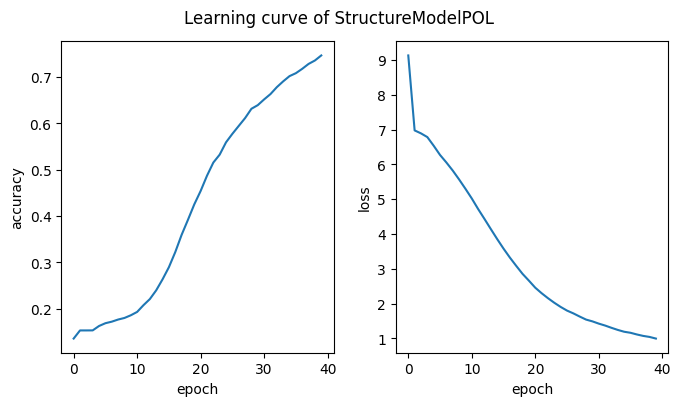

In [18]:
with open(f"data/models/{MODEL_NAME}/history.pickle", "rb") as f:
    history = pickle.load(f)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle(f"Learning curve of {MODEL_NAME}")

ax1.plot(history['accuracy'])
ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy')

ax2.plot(history['loss'])
ax2.set_xlabel('epoch')
ax2.set_ylabel('loss')
fig.tight_layout()
fig.set_size_inches(7, 4)
fig.savefig(f"data/models/{MODEL_NAME}/learning_curve.png")
plt.show()

In [20]:
print(generate_verse(MODEL, TOKENIZER, ""))

 ty ty tak tak tylko zaraźliwym 
 moja droga droga 
 każdy cię nieśmiertelny 
 najwyższą to mego moja jedna gwiazdą 



In [21]:
def similarity(a: tp.List[tp.List[int]], b: tp.List[int]):
    return np.dot(a, b)/(np.linalg.norm(a, axis=1) * np.linalg.norm(b))

def measure_structure_similarity(model: keras.Model, tokenizer: Tokenizer, text: str, tests: int = 20):
    a = [[len(line) for line in verse.split('\n')[:4]] for verse in text]
    words = list(TOKENIZER.word_index.keys())
    result = []
    for _ in tqdm(range(tests)):
        verse = generate_verse(model, tokenizer, random.choice(words))
        b = [len(line) for line in verse.split('\n')[:4]]
        sim = similarity(a, b)
        result.append(np.mean(sim))
    return np.mean(result)

MEAN_SIMILARITY = measure_structure_similarity(MODEL, TOKENIZER, TEXT)
print(f"Mean cousine similarity: {MEAN_SIMILARITY}")

100%|██████████| 20/20 [00:53<00:00,  2.68s/it]

Mean cousine similarity: 0.9699982963463819
